In [45]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
#Packages 
import numpy as np
import xarray as xr
import cmocean.cm as cmo
import matplotlib.pyplot as plt
import mpas_tools

from geometric_features import GeometricFeatures
from geometric_features import read_feature_collection

from mpas_tools.mesh.mask import compute_mpas_region_masks
from mpas_tools.parallel import create_pool
from mpas_tools.io import write_netcdf

import geojson
import json
import mosaic
import os.path
import mpasregions.sections as mps
import gsw
import warnings 
import glob
from xgcm import Grid

In [47]:
# global mesh
mesh_path = '/global/cfs/projectdirs/e3sm/inputdata/ocn/mpas-o/EC30to60E2r2/ocean.EC30to60E2r2.210210.nc'
mesh = xr.open_dataset(mesh_path)
mesh = mesh.assign_coords({
"VertexID": xr.DataArray(mesh.indexToVertexID, dims=('nVertices',)),
})

# global data
bmm_filepath = '/pscratch/sd/b/bmoorema/run_001_062/'
dso = xr.open_dataset(bmm_filepath + '20210421_sim7_CORE_60to30E2r2.mpaso.hist.am.timeSeriesStatsMonthly.0063-12-01.nc')

# open base mask that we will fill with 0s according to the original mask (this new mask will contain cells PLUS their corresponding edges and vertices)
# base_mask = xr.open_dataset('./mpas-o_EC30to60_global_base_mask.nc')


/tmp/ipykernel_2212659/4260513771.py:10: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  dso = xr.open_dataset(bmm_filepath + '20210421_sim7_CORE_60to30E2r2.mpaso.hist.am.timeSeriesStatsMonthly.0063-12-01.nc')


In [48]:
dso.xtime_startMonthly

months = ['01','02','03','04','05','06','07','08','09','10','11','12']
ds_list = []

prefix = '20210421_sim7_CORE_60to30E2r2.mpaso.hist.am.timeSeriesStats'

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i in range(0,12):
        month = months[i]
        file = prefix + f'Monthly.0063-{month}-01.nc'
        file_glob = glob.glob(file)
        ds = xr.open_dataset(bmm_filepath + file)[['xtime_startMonthly','timeMonthly_avg_normalVelocity','timeMonthly_avg_potentialDensity']]
        ds_xtime_startMonthly = ds.swap_dims({'Time':'xtime_startMonthly'})
        ds_list.append(ds_xtime_startMonthly)

dss = xr.concat(ds_list,dim='xtime_startMonthly')

In [85]:
ds_tmp =  xr.open_dataset(bmm_filepath + '20210421_sim7_CORE_60to30E2r2.mpaso.hist.am.timeSeriesStatsMonthly.0063-12-01.nc')

/tmp/ipykernel_2212659/1218758248.py:1: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds_tmp =  xr.open_dataset(bmm_filepath + '20210421_sim7_CORE_60to30E2r2.mpaso.hist.am.timeSeriesStatsMonthly.0063-12-01.nc')


In [83]:
ds

<xarray.Dataset> Size: 230MB
Dimensions:                           (Time: 1, nEdges: 719506,
                                       nVertLevels: 60, nCells: 236853)
Dimensions without coordinates: Time, nEdges, nVertLevels, nCells
Data variables:
    xtime_startMonthly                (Time) |S64 64B b'0063-12-01_00:30:00'
    timeMonthly_avg_normalVelocity    (Time, nEdges, nVertLevels) float32 173MB ...
    timeMonthly_avg_potentialDensity  (Time, nCells, nVertLevels) float32 57MB ...
Attributes: (12/722)
    on_a_sphere:                                                  YES
    sphere_radius:                                                6.371229e+06
    model_name:                                                   mpas
    core_name:                                                    ocean
    history:                                                      mpirun -n 6...
    source:                                                       MPAS
    ...                                                           ...
    config_AM_harmonicAnalysis_use_K2:                            YES
    config_AM_harmonicAnalysis_use_K1:                            YES
    config_AM_harmonicAnalysis_use_O1:                            YES
    config_AM_harmonicAnalysis_use_Q1:                            YES
    config_AM_harmonicAnalysis_use_P1:                            YES
    file_id:                                                      n8e14chhu8

```python
def extract_variables(ds):
    return ds[var_list]
xr.open_mfdataset(file = prefix + f'Monthly.0063-*-01.nc', preprocess=extract_variables)
```

In [49]:
# set up descriptor for plotting 
# # set up mesh to apply polypcolor
mesh.attrs['is_periodic'] = 'YES'
mesh.attrs['x_period'] = 360
mesh.attrs['y_period'] = 0.0

descriptor = mosaic.Descriptor(mesh,use_latlon=False)

### get edge and vertex indices for a transect created from an algorithm

In [50]:
LS_lats= np.array([54, 60, 66, 64, 58])   
LS_lons= np.array([302, 315, 310, 295, 296])

LS_lats = np.append(LS_lats, LS_lats[0])
LS_lons = np.append(LS_lons, LS_lons[0])

# # calculate transects from algorithm, sort vertices & edges to be in consecutive order
test_edges, test_verts = mps.calculate_transects_multiple_pts(LS_lons, LS_lats, mesh)

# from the transect, create a mask to capture the entire region specified by the transects
# this will also output lats and lons corresponding to test_verts
path = './'
filename = 'LS_test'
geojson_file_name = 'Labrador Sea from transect algorithm'
tags = "Labrador_Sea;Davis_Strait"
author = "Kaila Uyeda"

    
test_verts_lats, test_verts_lons, dsMasks = mps.transect_from_alg_create_nc(test_verts, 
                                                                            mesh, 
                                                                            path,
                                                                            filename, 
                                                                            geojson_file_name,
                                                                            tags, 
                                                                            author)

# use the dsMasks file to get the ACTUAL working vertices that you will need
# this eliminates duplicate vertices that would occur if the transect moves back on itself
# check that the vertices and edges from the mask are actually at the same plaaces...
# in other words, we have the correct cells for the mask but extra edges and vertices because of how the transect is created.
# we have to do this after we create a mask with the cells. Otherwise, we don't know what side of the boundary
# is considered "inside the mask"

alg_edges, alg_vertices = mps.find_and_sort_transect_edges_and_vertices(mesh,dsMasks)

LS_test_transect_from_alg.geojson exists!
Opening LS_test_transect_from_alg.nc as dsMasks


In [106]:
nEdges_along_boundary = xr.DataArray(np.arange(0, alg_edges.size), dims=("nEdges_along_boundary", ))
ds_boundary = xr.Dataset(coords={
    "nEdges_along_boundary": nEdges_along_boundary,
    "nEdges_ID": xr.DataArray(alg_edges, dims=("nEdges_along_boundary",))
})

In [107]:
ds_boundary

<xarray.Dataset> Size: 2kB
Dimensions:                (nEdges_along_boundary: 148)
Coordinates:
  * nEdges_along_boundary  (nEdges_along_boundary) int64 1kB 0 1 2 ... 146 147
    nEdges_ID              (nEdges_along_boundary) int32 592B 17579 ... 17579
Data variables:
    *empty*

In [51]:
# get just the OSNAP edges and vertices

OSNAP_target_start_lat = 54
OSNAP_target_start_lon = 302
OSNAP_target_end_lat = 60
OSNAP_target_end_lon = 315

# get the raw/test edges and vertices.
# we consider these to be "raw" because, by how these points have been chosen,
# cellsOnEdge[nEdge,0] = land cell and cellsOnEdge[nEdge,1] = open ocean not in mask
OSNAP_edges_raw, OSNAP_verts_raw = mps.calculate_transects(OSNAP_target_start_lat, OSNAP_target_start_lon, OSNAP_target_end_lat, OSNAP_target_end_lon, mesh)

# we know that the alg_edges, alg_vertices remove the above discussed edges and vertices by how we define edges on transect 
# take the intersection of OSNAP_*_raw with alg_* to only get the edges and vertices along the transect
OSNAP_edges = np.intersect1d(OSNAP_edges_raw, alg_edges)
OSNAP_vertices = np.intersect1d(OSNAP_verts_raw, alg_vertices)

### get edge and vertex indices for a transect created from a mask

In [52]:
# open mask of desired region (this is to find transects from a pre-existing mask)

path = './'
filename = 'LS_test_transect_from_mask'

check_nc_existence = os.path.isfile(path + filename + '.nc')

# check if .nc mask file exists
if check_nc_existence == True:
    print(f'Opening {filename}.nc file as mask')
    mask = xr.open_dataset(path + filename + '.nc')
else: 
    print('Creating .nc file')
    check_geojson_existence = os.path.isfile(path + filename + '.geojson')

    # convert LS_test.geojson to LS_test.nc mask file
    if check_geojson_existence == True:
        print(f'Using {filename}.geojson to create .nc file')
        fcMask = read_feature_collection(path + filename + '.geojson')
        # pool = create_pool(process_count=8)
        dsMasks = compute_mpas_region_masks(mesh, fcMask, maskTypes =('cell',), pool=pool)
        dsMasks.to_netcdf(path + filename + '.nc', format='NETCDF4', mode='w')
        mask = xr.open_dataset(path + filename + '.nc')
        print(f'{filename}.nc created and opened as masks')
    else:
        print(f'{filename}.geojson does NOT exist!')

mask_edges, mask_vertices = mps.find_and_sort_transect_edges_and_vertices(mesh,mask)

Opening LS_test_transect_from_mask.nc file as mask


### Set up choice of edges and vertices based on method of creation.

In [53]:
method = 'alg' # 'mask'
if method == 'alg':
    edges, vertices = alg_edges, alg_vertices
    mask = dsMasks

if method == 'mask':
    edges, vertices = mask_edges, mask_vertices
    mask = mask

### A note on sign convention from normal velocity taken from [this python script on Github](https://github.com/milenaveneziani/analysis/blob/c7eb78deabb6fe9529d43fecdae6ce700eefff38/common_functions.py#L119) where 
`cellsOnEdge[nEdge,0]` is equivalent to my use of `A` cell, and \
`cellsonEdge[nEdge,1]` is equivalent to my use of `B` cell.

```ruby
# Compute edgeSigns so that transport INTO the region is positive. This is 
    # calculated considering that normalVelocity is positive when pointing from
    # cellsOnEdges[nEdge, 0] to cellsOnEdges[nEdge, 1]. Therefore, if 
    # cellsOnEdges[nEdge, 0] is outside the region and cellsOnEdges[nEdge, 1]
    # is inside the region, the sign remains unchanged (np.sign(regionMask[cellsOnEdges[nEdge, 1]] - 0.5)=1).
    # But, if cellsOnEdges[nEdge, 0] is inside the region and cellsOnEdges[nEdge, 1]
    # is outside the region, then the sign is flipped (np.sign(regionMask[cellsOnEdges[nEdge, 1]] - 0.5)
    # becomes -1. With this reasoning, the following also works (and we have verified that):
    # openBoundarySigns = -np.sign(regionMask[cellsOnEdges[~landEdges, 0]] - 0.5)
```

In [54]:
# Use normal velocity to calculate transport direction (We want positive into the mask and negative out of the mask)
# We make the assumption that normal velocity is positive toward the A cell where mesh.cellsOnEdge = [A,B]

# create a new datavariable for the velocity into the mask to be stored (we will change the normal velocity sign)
# I only subtract 100 because I want to show where land is (nans) and make that distinct from places in the ocean that aren't part of 
# the mask (-100)
def calculate_velo_into_mask(dso, mesh, mask, outside_mask_values):
    dso['veloIntoMask'] = dso.timeMonthly_avg_normalVelocity * 0 + outside_mask_values
    
    # find edges on land
    xr_all_edgesOnLand_TWO0 = mesh.nEdges.where(np.isin(mesh.cellsOnEdge.isel(TWO=0),0))
    xr_all_edgesOnLand_TWO1 = mesh.nEdges.where(np.isin(mesh.cellsOnEdge.isel(TWO=1),0))
    xr_all_edgesOnLand = np.union1d(xr_all_edgesOnLand_TWO0, xr_all_edgesOnLand_TWO1)
    
    # of those edges on land, get only the ones that are part of the transect
    xr_transect_edgesOnLand = np.intersect1d(edges, xr_all_edgesOnLand)
    
    # get only the open ocean edges
    xr_transect_edgesOnOcean = np.setxor1d(edges, xr_transect_edgesOnLand) 
    
    # make these values a coordinate. This will allow us to later .isel instead of .where without losing the nEdges dimension used to identify the edges
    xr_transect_edgesOnOcean_da = xr.DataArray(
        np.int32(xr_transect_edgesOnOcean),
        coords={"nEdges":np.int32(xr_transect_edgesOnOcean)},
        dims=("nEdges",))
    
    
    # select all the cells inside the mask
    xr_cells_inside, ignore_xr_inside_edges, ignore_xr_inside_vertices = mps.xr_inside_mask_info(mesh,mask)
    
    # of these open ocean edges, determine if the normal velocity is into or out of the mask
    
    # find the cells on open ocean edges
    n_transect_cellsOnOceanEdges =  mesh.cellsOnEdge.isel(nEdges = xr_transect_edgesOnOcean_da)
    xr_transect_cellsOnOceanEdges = mps.n_to_xr_idx(n_transect_cellsOnOceanEdges)

    # determine if the normal velocity points into or out of the mask
    
    for i in range(0,len(xr_transect_edgesOnOcean)):
        cellsOnSelectedEdge = xr_transect_cellsOnOceanEdges.isel(nEdges = i)
        selectedEdge = xr_transect_cellsOnOceanEdges.nEdges[i]
        
        if cellsOnSelectedEdge.isel(TWO=0).isin(xr_cells_inside): # if A is in the mask 
            dso.veloIntoMask.loc[dict(Time=0, nEdges = selectedEdge)] = dso.timeMonthly_avg_normalVelocity.loc[dict(Time=0,nEdges= selectedEdge)] * -1
            
        elif cellsOnSelectedEdge.isel(TWO=1).isin(xr_cells_inside): # if B is in the mask
            dso.veloIntoMask.loc[dict(Time=0, nEdges = selectedEdge)] = dso.timeMonthly_avg_normalVelocity.loc[dict(Time=0,nEdges = selectedEdge)] * 1

    return mesh,xr_transect_cellsOnOceanEdges

In [55]:
# Use normal velocity to calculate transport direction (We want positive into the mask and negative out of the mask)
# We make the assumption that normal velocity is positive toward the A cell where mesh.cellsOnEdge = [A,B]

# create a new datavariable for the velocity into the mask to be stored (we will change the normal velocity sign)
# I only subtract 100 because I want to show where land is (nans) and make that distinct from places in the ocean that aren't part of 
# the mask (-100)
def calculate_velo_into_mask(dso, mesh, mask, outside_mask_values):
    dso['veloIntoMask'] = dso.timeMonthly_avg_normalVelocity * 0 + outside_mask_values
    
    # find edges on land
    xr_all_edgesOnLand_TWO0 = mesh.nEdges.where(np.isin(mesh.cellsOnEdge.isel(TWO=0),0))
    xr_all_edgesOnLand_TWO1 = mesh.nEdges.where(np.isin(mesh.cellsOnEdge.isel(TWO=1),0))
    xr_all_edgesOnLand = np.union1d(xr_all_edgesOnLand_TWO0, xr_all_edgesOnLand_TWO1)
    
    # of those edges on land, get only the ones that are part of the transect
    xr_transect_edgesOnLand = np.intersect1d(edges, xr_all_edgesOnLand)
    
    # get only the open ocean edges
    xr_transect_edgesOnOcean = np.setxor1d(edges, xr_transect_edgesOnLand) 
    
    # make these values a coordinate. This will allow us to later .isel instead of .where without losing the nEdges dimension used to identify the edges
    xr_transect_edgesOnOcean_da = xr.DataArray(
        np.int32(xr_transect_edgesOnOcean),
        coords={"nEdges":np.int32(xr_transect_edgesOnOcean)},
        dims=("nEdges",))
    
    
    # select all the cells inside the mask
    xr_cells_inside, ignore_xr_inside_edges, ignore_xr_inside_vertices = mps.xr_inside_mask_info(mesh,mask)
    
    # of these open ocean edges, determine if the normal velocity is into or out of the mask
    
    # find the cells on open ocean edges
    n_transect_cellsOnOceanEdges =  mesh.cellsOnEdge.isel(nEdges = xr_transect_edgesOnOcean_da)
    xr_transect_cellsOnOceanEdges = mps.n_to_xr_idx(n_transect_cellsOnOceanEdges)

    # determine if the normal velocity points into or out of the mask
    
    for i in range(0,len(xr_transect_edgesOnOcean)):
        for j in range(0,len(dso.xtime_startMonthly)):
            cellsOnSelectedEdge = xr_transect_cellsOnOceanEdges.isel(nEdges = i)
            selectedEdge = xr_transect_cellsOnOceanEdges.nEdges[i]
            selectedMonth = dso.xtime_startMonthly[j]
            
            if cellsOnSelectedEdge.isel(TWO=0).isin(xr_cells_inside): # if A is in the mask 
                dso.veloIntoMask.loc[dict(xtime_startMonthly=selectedMonth, nEdges = selectedEdge)] = dso.timeMonthly_avg_normalVelocity.loc[dict(xtime_startMonthly=selectedMonth,nEdges= selectedEdge)] * -1
                
            elif cellsOnSelectedEdge.isel(TWO=1).isin(xr_cells_inside): # if B is in the mask
                dso.veloIntoMask.loc[dict(xtime_startMonthly=selectedMonth, nEdges = selectedEdge)] = dso.timeMonthly_avg_normalVelocity.loc[dict(xtime_startMonthly=selectedMonth,nEdges = selectedEdge)] * 1

    return dso,xr_transect_cellsOnOceanEdges

In [56]:
outside_mask_values = np.nan
# mesh_plot, xr_transect_cellsOnOceanEdges = calculate_velo_into_mask(mesh,mask,outside_mask_values)

In [57]:
dso, xr_transect_cellsOnOceanEdges = calculate_velo_into_mask(dss,mesh,mask,outside_mask_values)

In [58]:
# fig,ax = plt.subplots(nrows=1,ncols=1,constrained_layout=True,figsize=(14,10))

# c = mosaic.polypcolor(ax,descriptor,
#                   mesh_plot.veloIntoMask.isel(Time=0,nVertLevels=10),cmap='RdBu_r', vmin=-0.5,vmax=0.5,
#                   antialiaseds=False)
# ax.set_xlim(290, 318)
# ax.set_ylim(51.5, 68)
# fig.colorbar(c, extend='both')
# # this is making me feel like I should flip the signs of the for loop

In [59]:
# calculate the area of the edge-layerThickness plane that the normal velocity moves through

# --------- INTERPOLATE LAYER THICKNESS ONTO NEDGES ---------
# layerThickness sits on nCells, but veloIntoMask sits on nEdges
# we need to interpolate layerThickness onto nEdges by taking the average of the layerThickness of 2 cells that sit on the transect edge

# select only the layerThicknesses that are on edges in the transect
cellsOnTransectEdge_layerThickness = mesh.layerThickness.isel(Time=0, nCells = xr_transect_cellsOnOceanEdges)

# take the mean of the layer thicknesses along the dimension "TWO" (take the mean of layer thickness between TWO=0 cell and TWO=1 cell)
interp_transectEdgeLayerThickness = cellsOnTransectEdge_layerThickness.mean(dim='TWO')

# --------- FIND THE WIDTH OF EACH TRANSECT EDGE---------
# find the dvEdge for all edges in transect
transectEdgeLength = mesh.dvEdge.isel(nEdges = xr_transect_cellsOnOceanEdges.nEdges)

# --------- CALCULATE THE CROSS-SECTIONAL AREA OF THE TRANSECT BY MULTIPLYING THE LAYERTHICKNESS BY THE EDGELENGTH ---------
transect_area = interp_transectEdgeLayerThickness * transectEdgeLength

# --------- CALCULATE THE TRANSPORT INTO THE MASK --------
# multiply the cross-sectional area by the veloIntoMask
transport = transect_area * dso.veloIntoMask.isel(nEdges = xr_transect_cellsOnOceanEdges.nEdges)

<xarray.DataArray 'dvEdge' (nEdges: 719506)> Size: 6MB
[719506 values with dtype=float64]
Dimensions without coordinates: nEdges
Attributes:
    units:      m
    long_name:  Length of each edge, computed as the distance between vertice...

In [132]:
transport_neg = transport.where(transport < 0)
transport_pos = transport.where(transport > 0)

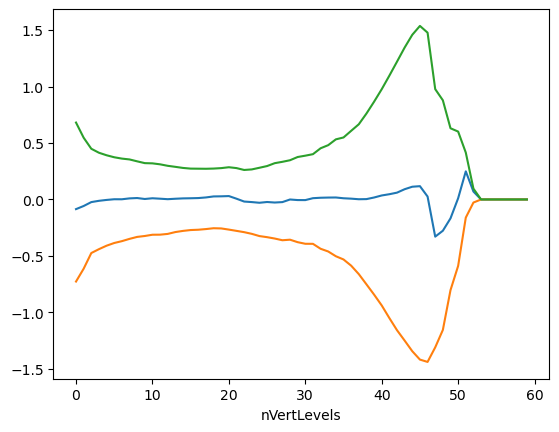

In [133]:
(transport.where(transport!=0).mean("xtime_startMonthly").sum("nEdges")*1e-6).plot()
(transport_neg.where(transport_neg!=0).mean("xtime_startMonthly").sum("nEdges")*1e-6).plot()
(transport_pos.where(transport_pos!=0).mean("xtime_startMonthly").sum("nEdges")*1e-6).plot()

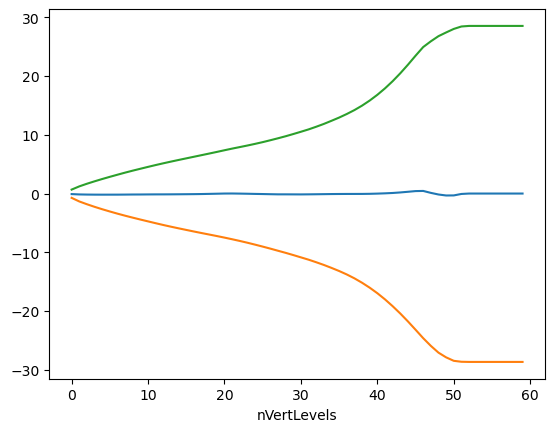

In [137]:
np.cumsum(transport.where(transport!=0).mean("xtime_startMonthly").sum("nEdges")*1e-6).plot()
np.cumsum(transport_neg.where(transport_neg!=0).mean("xtime_startMonthly").sum("nEdges")*1e-6).plot()
np.cumsum(transport_pos.where(transport_pos!=0).mean("xtime_startMonthly").sum("nEdges")*1e-6).plot()

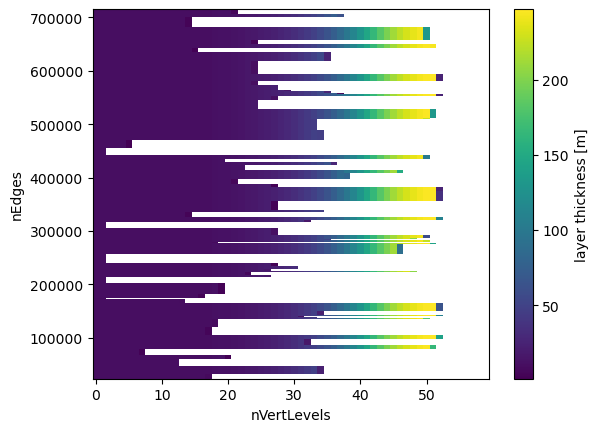

In [115]:
cellsOnTransectEdge_layerThickness.where(cellsOnTransectEdge_layerThickness!=0).isel(TWO=0).plot()

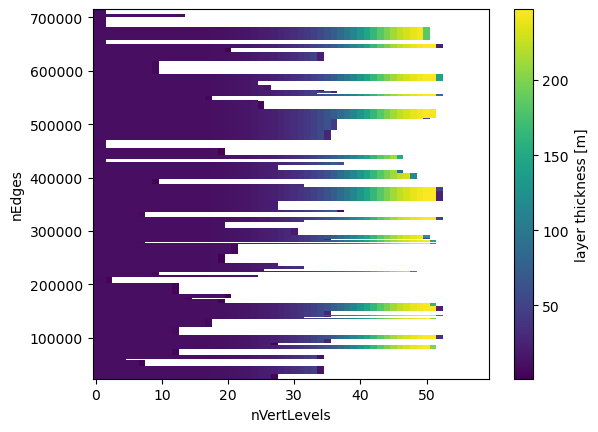

In [116]:
cellsOnTransectEdge_layerThickness.where(cellsOnTransectEdge_layerThickness!=0).isel(TWO=1).plot()

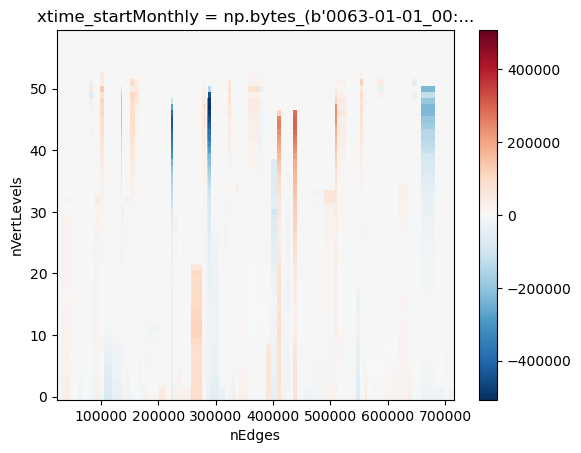

In [97]:
transport.isel(xtime_startMonthly=0).plot(x="nEdges")

In [60]:
# create a new datavariable for transport, assign the transport to the corresponding edge
dso['transportIntoMask'] = dso.veloIntoMask * 0 + np.nan

for i in range(0,len(interp_transectEdgeLayerThickness)):
    for j in range(0,len(dso.xtime_startMonthly)):
        selectedEdge = transport.nEdges.isel(nEdges=i)
        selectedMonth = dso.xtime_startMonthly[j]
    
        dso.transportIntoMask.loc[dict(xtime_startMonthly=selectedMonth, nEdges = selectedEdge)] = transport.loc[dict(xtime_startMonthly = selectedMonth, nEdges = selectedEdge)]

transportIntoMask_Sv = dso.transportIntoMask / 10**6

In [61]:
# from the transect, create a mask to capture the entire region specified by the transects
# this will also output lats and lons corresponding to test_verts
filepath = './'
filename = 'LS_test'
geojson_file_name = 'Labrador Sea from transect algorithm'
tags = "Labrador_Sea;Davis_Strait"
author = "Kaila Uyeda"

test_verts_lats, test_verts_lons, dsMasks = mps.transect_from_alg_create_nc(test_verts, 
                                                                            mesh, 
                                                                            filepath,
                                                                            filename, 
                                                                            geojson_file_name,
                                                                            tags, 
                                                                            author)

LS_test_transect_from_alg.geojson exists!
Opening LS_test_transect_from_alg.nc as dsMasks


In [62]:
net_transportIntoMask_Sv = transportIntoMask_Sv.sum(dim=['nEdges','nVertLevels'])
net_transportIntoMask_Sv.mean(dim='xtime_startMonthly')

<xarray.DataArray 'transportIntoMask' ()> Size: 8B
array(0.00741641)

In [93]:
transportIntoMask_Sv

<xarray.DataArray 'transportIntoMask' (nEdges: 719506, nVertLevels: 60)> Size: 173MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]],
      shape=(719506, 60), dtype=float32)
Coordinates:
    xtime_startMonthly  |S64 64B b'0063-01-01_00:30:00'
Dimensions without coordinates: nEdges, nVertLevels

In [63]:
column_transport = dso.transportIntoMask.isel(xtime_startMonthly=0).sum(dim='nVertLevels')
OSNAP_column_transport = column_transport.where(np.isin(mesh.nEdges, OSNAP_edges))
OSNAP_column_transport_Sv = OSNAP_column_transport / 10**6

In [64]:
non_OSNAP_column_transport = column_transport.where(~np.isin(mesh.nEdges, OSNAP_edges))
non_OSNAP_column_transport = non_OSNAP_column_transport / 10**6

In [65]:
# PLOT JUST OSNAP
# fig,ax = plt.subplots(nrows=1,ncols=1,constrained_layout=True,figsize=(14,10))

# cellmask = dsMasks.regionCellMasks.isel(nRegions=0).astype(bool)
# b = mosaic.polypcolor(ax,descriptor,
#                   cellmask.astype(int),cmap='cool',alpha = 0.4,
#                   antialiaseds=False)


# c = mosaic.polypcolor(ax,descriptor,
#                   OSNAP_column_transport_Sv,cmap=cmo.balance,vmin=-10,vmax=10,
#                   antialiaseds=False)
# ax.set_xlim(290, 318)
# ax.set_ylim(51.5, 68)
# fig.colorbar(c, extend='both')
# ax.set_title('Net transport into mask through "OSNAP" array is ' + OSNAP_rounded_total_transport)
# # this is making me feel like I should flip the signs of the for loop?? 
# # But then this would mean there's a net increase of water in this region instead of export

In [66]:
# PLOT A SELECTED LEVEL
# fig,ax = plt.subplots(nrows=1,ncols=1,constrained_layout=True,figsize=(14,10))

# cellmask = dsMasks.regionCellMasks.isel(nRegions=0).astype(bool)
# b = mosaic.polypcolor(ax,descriptor,
#                   cellmask.astype(int),cmap='cool',alpha = 0.4,
#                   antialiaseds=False)


# c = mosaic.polypcolor(ax,descriptor,
#                   transportIntoMask_Sv.isel(Time=0,nVertLevels=20),cmap=cmo.balance,vmin=-0.05,vmax=0.05,
#                   antialiaseds=False)
# ax.set_xlim(290, 318)
# ax.set_ylim(51.5, 68)
# fig.colorbar(c, extend='both')
# # this is making me feel like I should flip the signs of the for loop?? 
# # But then this would mean there's a net increase of water in this region instead of export

In [67]:
OSNAP_rounded_total_transport = str(np.round(OSNAP_column_transport_Sv.sum().values,decimals=3))
str_net_transportIntoMask_Sv = str(np.round(net_transportIntoMask_Sv.values,decimals=3))
str_nonOSNAP_transportIntoMask_Sv = str(np.round(non_OSNAP_column_transport.sum().values,decimals=3))

Text(0.5, 1.0, 'Net transport into mask is [ 0.001 -0.085 -0.03  -0.064  0.04   0.057  0.043 -0.012  0.067  0.045\n  0.039 -0.013]Sv \n OSNAP: -0.209 & non-OSNAP: 0.21')

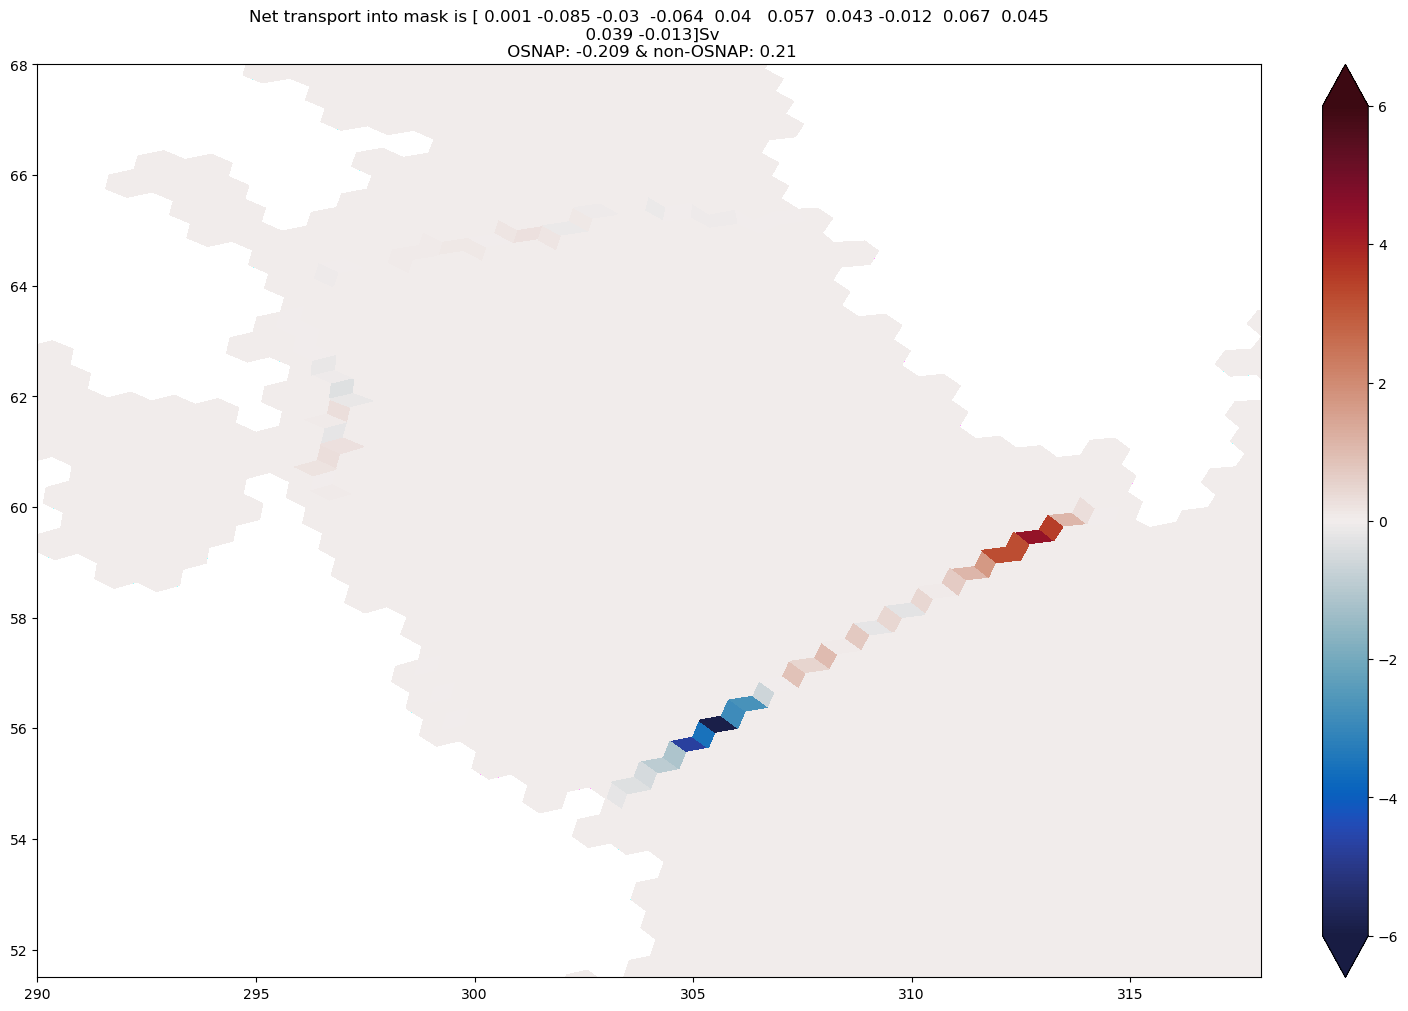

In [68]:

fig,ax = plt.subplots(nrows=1,ncols=1,constrained_layout=True,figsize=(14,10))

cellmask = dsMasks.regionCellMasks.isel(nRegions=0).astype(bool)
b = mosaic.polypcolor(ax,descriptor,
                  cellmask.astype(int),cmap='cool',alpha = 0.4,
                  antialiaseds=False)

c = mosaic.polypcolor(ax,descriptor,
                  transportIntoMask_Sv.sum(dim='nVertLevels').mean(dim='xtime_startMonthly'),cmap=cmo.balance,vmin=-6,vmax=6,
                  antialiaseds=False)


ax.set_xlim(290, 318)
ax.set_ylim(51.5, 68)
fig.colorbar(c, extend='both')
ax.set_title('Net transport into mask is ' + str_net_transportIntoMask_Sv + 'Sv \n OSNAP: ' + OSNAP_rounded_total_transport + ' & non-OSNAP: ' + str_nonOSNAP_transportIntoMask_Sv)
# this is making me feel like I should flip the signs of the for loop?? 
# But then this would mean there's a net increase of water in this region instead of export

```ruby
 'config_eos_linear_alpha': np.float64(0.2), 'config_eos_linear_beta': np.float64(0.8),
 'config_eos_linear_Tref': np.float64(5.0),
 'config_eos_linear_Sref': np.float64(35.0),
 'config_eos_linear_densityref': np.float64(1000.0),
 'config_eos_type': 'jm',
 ```
### [Fortran code for JM equation of state in MPAS-Ocean](https://github.com/kailauyeda/E3SM/blob/aab1d951cb7e6dcae737f8412109607efd25f2e3/components/mpas-ocean/src/shared/mpas_ocn_equation_of_state_jm.F#L17)
(unfortunately, I have no idea if there ie s a Python package that will calculate this...)

### to look at transport for a density bin that is greater than 1027.7 kg/m^3

In [69]:
print('masked sigma max is 1027? That\'s it??')

masked sigma max is 1027? That's it??


In [70]:
# we want to select only the potential density values greater than 1025
# to do so, we need to interpolate potential density (on nCells) onto nEdges
cellsOnTransectEdge_sigma = dso.timeMonthly_avg_potentialDensity.isel(nCells=xr_transect_cellsOnOceanEdges)

# take the mean of the potential density along the dimension "TWO" (take the mean of sigma between TWO=0 cell and TWO=1 cell)
interp_transectEdgeSigma = cellsOnTransectEdge_sigma.mean(dim='TWO')

# reassign the interpolated sigma datavariable that now sit on the cell edge instead of cell center 
# create a new datavariable for transport, assign the transport to the corresponding edge
dso['edgeSigma'] = dso.transportIntoMask * 0 + np.nan

dso.edgeSigma.loc[dict(xtime_startMonthly=dso.xtime_startMonthly, nEdges = interp_transectEdgeSigma.nEdges)] = interp_transectEdgeSigma.loc[dict(xtime_startMonthly=dso.xtime_startMonthly,nEdges = interp_transectEdgeSigma.nEdges)]
# for i in range(0,len(interp_transectEdgeSigma)):
#     selectedEdge = interp_transectEdgeSigma.nEdges.isel(nEdges=i)
    
#     mesh.edgeSigma.loc[dict(Time=0, nEdges = selectedEdge)] = interp_transectEdgeSigma.loc[dict(nEdges = selectedEdge)]

edgeSigma_mask = dso.edgeSigma#.isel(Time=0)

In [71]:
edgeSigma_nadw = edgeSigma_mask > 1027.7
np.count_nonzero(edgeSigma_nadw.astype(int)==1)

np.int64(4817)

In [72]:
nadw_transportMask_attempt = dso.transportIntoMask.where(edgeSigma_nadw ==True)

In [73]:
full_column_transport = transportIntoMask_Sv.sum(dim='nVertLevels') 
nadw_column_transport = nadw_transportMask_attempt.sum(dim='nVertLevels') / 10**6

### to look at transport for all density bins

In [74]:
dso_mini = dso[['edgeSigma','transportIntoMask']].isel(nEdges = xr_transect_cellsOnOceanEdges.nEdges)

# create vertical xgcm grid
grid = Grid(dso, coords={'Z':{'center':'nVertLevels'}},periodic=False,autoparse_metadata=False)

# define target values in density
edgeSigma_target = np.linspace(999,1028,60)

# transform
transport_transformed = grid.transform(dso_mini.transportIntoMask, 'Z', edgeSigma_target, target_data = dso_mini.edgeSigma)
mean_transport = transport_transformed.sum('nEdges').mean(dim='xtime_startMonthly') / 10**6
cs_mean_transport = np.flipud(mean_transport.cumsum())
cs_mean_transport

/global/homes/k/kuyeda/.conda/envs/lanl_env/lib/python3.13/site-packages/numba/np/ufunc/gufunc.py:263: RuntimeWarning: divide by zero encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)
/global/homes/k/kuyeda/.conda/envs/lanl_env/lib/python3.13/site-packages/numba/np/ufunc/gufunc.py:263: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)


array([-2.59777150e+00, -2.59777150e+00, -2.51555856e+00, -2.53615749e+00,
       -2.52408818e+00, -2.51630011e+00, -2.49721924e+00, -2.41623366e+00,
       -2.31918576e+00, -2.21819851e+00, -2.11465657e+00, -2.01024245e+00,
       -1.90892321e+00, -1.81069885e+00, -1.71556937e+00, -1.62353477e+00,
       -1.53459505e+00, -1.44875022e+00, -1.36600026e+00, -1.28634518e+00,
       -1.20978499e+00, -1.13631967e+00, -1.06594924e+00, -9.98673685e-01,
       -9.34493012e-01, -8.73407220e-01, -8.15416309e-01, -7.60520278e-01,
       -7.08719128e-01, -6.60012859e-01, -6.13042258e-01, -5.69245052e-01,
       -5.28228404e-01, -4.88552899e-01, -4.50379049e-01, -4.13756816e-01,
       -3.78687316e-01, -3.45170551e-01, -3.13206519e-01, -2.82795221e-01,
       -2.53936657e-01, -2.26630827e-01, -2.00877731e-01, -1.76677368e-01,
       -1.54029740e-01, -1.32934846e-01, -1.13392685e-01, -9.54032581e-02,
       -7.89665652e-02, -6.40826062e-02, -5.07513811e-02, -3.89728898e-02,
       -2.87471325e-02, -

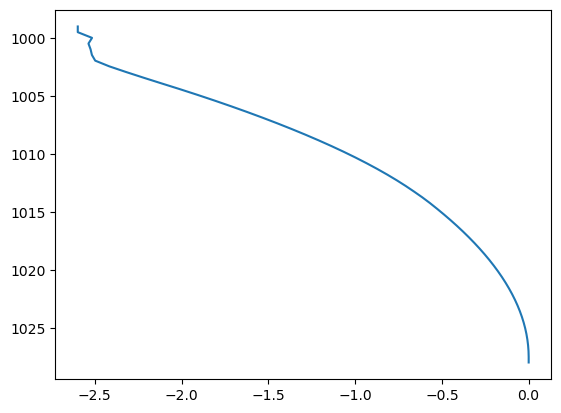

In [75]:
plt.plot(cs_mean_transport,edgeSigma_target)
plt.gca().invert_yaxis()

In [76]:
# multiindex to allow for binning transport by density
# .isel for nEdges that are along the tansect edge...
dso_mini = dso[['edgeSigma','transportIntoMask']].isel(nEdges = xr_transect_cellsOnOceanEdges.nEdges)
dso_mini

# create arrays from the values of coordinates in the mini dso
nEdge_array = dso_mini.nEdges.values
nVertLevels_array = dso_mini.nVertLevels.values
xtime_startMonthly_array = dso.xtime_startMonthly.values

# there's probably a more efficient, clear way to do this, but I cannot think of one rn
# swap dims for edges and vertices, but preserve the time dimension
# then re-concatenate the datasets so that there are edgesigma for every time step (month)
stacked_dso_mini = dso_mini.stack(edges_vertices = ('nEdges','nVertLevels'))
ds_swapped_dims_list = []
for i in range(0,len(stacked_dso_mini.xtime_startMonthly)):
    ds_byMonth = stacked_dso_mini.isel(xtime_startMonthly=i).swap_dims({'edges_vertices':'edgeSigma'})
    ds_byMonth_expand_dims = ds_byMonth.expand_dims(dim='xtime_startMonthly')
    ds_swapped_dims_list.append(ds_byMonth_expand_dims)

ds_swapped_dims = xr.concat(ds_swapped_dims_list,dim='edgeSigma')

# for each of the density bins, calculate the average 
# I'm going to try to bin first and then average those bins... 
# say there's a bunch of dense water transport in DJF (more than the yearly average)
# if we were to take a yearly average first, then we wouldn't see this transport at that density bin (it'd be accounted for at a lower transport 
# where the lower transport is due to an average transport that is lower than the dense water transport...

# to bin the data by density (edgeSigma), we will use xgcm
grid = Grid(dso, coords={'Z':{'center':'nVertLevels'}},periodic=False,autoparse_metadata=False)

# define the target values in edgeSigma
edgeSigma_target = np.linspace(999,1028,60)

# # transform
# nVertLevels_transformed = grid.transform(ds_swapped_dims.edgeSigma, 'Z', edgeSigma_target, target_data = ds_swapped_dims.transportIntoMask)
# nVertLevels_transformed

In [77]:
dso

<xarray.Dataset> Size: 9GB
Dimensions:                           (xtime_startMonthly: 12, nEdges: 719506,
                                       nVertLevels: 60, nCells: 236853)
Coordinates:
  * xtime_startMonthly                (xtime_startMonthly) |S64 768B b'0063-0...
Dimensions without coordinates: nEdges, nVertLevels, nCells
Data variables:
    timeMonthly_avg_normalVelocity    (xtime_startMonthly, nEdges, nVertLevels) float32 2GB ...
    timeMonthly_avg_potentialDensity  (xtime_startMonthly, nCells, nVertLevels) float32 682MB ...
    veloIntoMask                      (xtime_startMonthly, nEdges, nVertLevels) float32 2GB ...
    transportIntoMask                 (xtime_startMonthly, nEdges, nVertLevels) float32 2GB ...
    edgeSigma                         (xtime_startMonthly, nEdges, nVertLevels) float32 2GB ...
Attributes: (12/722)
    on_a_sphere:                                                  YES
    sphere_radius:                                                6.371229e+06
    model_name:                                                   mpas
    core_name:                                                    ocean
    history:                                                      mpirun -n 6...
    source:                                                       MPAS
    ...                                                           ...
    config_AM_harmonicAnalysis_use_K2:                            YES
    config_AM_harmonicAnalysis_use_K1:                            YES
    config_AM_harmonicAnalysis_use_O1:                            YES
    config_AM_harmonicAnalysis_use_Q1:                            YES
    config_AM_harmonicAnalysis_use_P1:                            YES
    file_id:                                                      5gwow45q1b

In [78]:
ds_swapped_dims

<xarray.Dataset> Size: 4MB
Dimensions:             (xtime_startMonthly: 12, edgeSigma: 59760)
Coordinates:
  * xtime_startMonthly  (xtime_startMonthly) |S64 768B b'0063-01-01_00:30:00'...
  * edgeSigma           (edgeSigma) float32 239kB 1.026e+03 1.026e+03 ... 999.7
    edges_vertices      (edgeSigma) object 478kB (27655, 0) ... (710530, 59)
    nEdges              (edgeSigma) int32 239kB 27655 27655 ... 710530 710530
    nVertLevels         (edgeSigma) int64 478kB 0 1 2 3 4 5 ... 55 56 57 58 59
Data variables:
    transportIntoMask   (xtime_startMonthly, edgeSigma) float32 3MB -7.52e+03...
Attributes: (12/722)
    on_a_sphere:                                                  YES
    sphere_radius:                                                6.371229e+06
    model_name:                                                   mpas
    core_name:                                                    ocean
    history:                                                      mpirun -n 6...
    source:                                                       MPAS
    ...                                                           ...
    config_AM_harmonicAnalysis_use_K2:                            YES
    config_AM_harmonicAnalysis_use_K1:                            YES
    config_AM_harmonicAnalysis_use_O1:                            YES
    config_AM_harmonicAnalysis_use_Q1:                            YES
    config_AM_harmonicAnalysis_use_P1:                            YES
    file_id:                                                      5gwow45q1b

In [79]:
bin0 = list(binned_transport.groups.keys())[0]
print(binned_transport.apply(lambda x:x).sel(edgeSigma=bin0))

NameError: name 'binned_transport' is not defined

In [ ]:
# multiindex to allow for binning transport by density
# .isel for nEdges that are along the tansect edge...
mesh_mini = mesh[['edgeSigma','transportIntoMask']].isel(Time=0,nEdges = xr_transect_cellsOnOceanEdges.nEdges)

# create arrays from the values of coordinates in the mini mesh
nEdge_array = mesh_mini.nEdges.values
nVertLevels_array = mesh_mini.nVertLevels.values

stacked_mesh_mini = mesh_mini.stack(edges_vertices = ('nEdges','nVertLevels'))
# stacked_mesh_mini.edges_vertices

# collect the transports and sigmas
transport_nadw = stacked_mesh_mini.transportIntoMask
sigma_nadw = stacked_mesh_mini.edgeSigma
# nadw_edges_vertices = transport_nadw.edges_vertices

# convert to datasets
transport_nadw_ds = transport_nadw.to_dataset(name='transportIntoMask')
sigma_nadw_ds = sigma_nadw.to_dataset(name='edgeSigma')

# merge the edgeSigma and transportIntoMask datasets to become one single dataset 
# just in case a .where would take too long
stacked_mesh_mini = xr.merge([transport_nadw_ds, sigma_nadw_ds])

# convert edgeSigma into a coordinate
transport_from_edgeSigma = stacked_mesh_mini.swap_dims({"edges_vertices":"edgeSigma"})
transport_from_edgeSigma

# bin transportIntoMask by edgeSigma values
sigma_bins = np.linspace(1024.4,1028,30)
grouped_transport = transport_from_edgeSigma.transportIntoMask.groupby_bins(transport_from_edgeSigma.edgeSigma,bins=sigma_bins)

# get the sum of transport for each density bin
grouped_transport_sum = grouped_transport.sum() / 10**6

In [ ]:
# multiindex to allow for binning transport by density
# .isel for nEdges that are along the tansect edge...
mesh_mini = mesh[['edgeSigma','transportIntoMask']].isel(Time=0,nEdges = xr_transect_cellsOnOceanEdges.nEdges)

# create arrays from the values of coordinates in the mini mesh
nEdge_array = mesh_mini.nEdges.values
nVertLevels_array = mesh_mini.nVertLevels.values

stacked_mesh_mini = mesh_mini.stack(edges_vertices = ('nEdges','nVertLevels'))
# stacked_mesh_mini.edges_vertices

# collect the transports and sigmas
transport_nadw = stacked_mesh_mini.transportIntoMask
sigma_nadw = stacked_mesh_mini.edgeSigma
# nadw_edges_vertices = transport_nadw.edges_vertices

# convert to datasets
transport_nadw_ds = transport_nadw.to_dataset(name='transportIntoMask')
sigma_nadw_ds = sigma_nadw.to_dataset(name='edgeSigma')

# merge the edgeSigma and transportIntoMask datasets to become one single dataset 
# just in case a .where would take too long
stacked_mesh_mini = xr.merge([transport_nadw_ds, sigma_nadw_ds])

# convert edgeSigma into a coordinate
transport_from_edgeSigma = stacked_mesh_mini.swap_dims({"edges_vertices":"edgeSigma"})
transport_from_edgeSigma

# bin transportIntoMask by edgeSigma values
sigma_bins = np.linspace(1024.4,1028,30)
grouped_transport = transport_from_edgeSigma.transportIntoMask.groupby_bins(transport_from_edgeSigma.edgeSigma,bins=sigma_bins)

# get the sum of transport for each density bin
grouped_transport_sum = grouped_transport.sum() / 10**6

In [ ]:
transport_from_edgeSigma.edgeSigma.max()

In [ ]:
grouped_transport

In [ ]:
len(sigma_bins[1:])

In [ ]:
grouped_transport_sum = grouped_transport.sum() / 10**6
grouped_transport_cumsum_denseToLight = np.flipud(grouped_transport_sum.cumsum())
grouped_transport_cumsum_denseToLight

In [ ]:
grouped_transport_sum.cumsum()

In [ ]:
grouped_transport_cumsum_denseToLight

In [ ]:
grouped_transport_sum

In [ ]:
# plot this 
fig,ax = plt.subplots(nrows=1,ncols=1,constrained_layout=True)
ax.plot(grouped_transport_cumsum_denseToLight, sigma_bins[1:])
ax.invert_yaxis()
ax.axvline(x=0,ls='--',color='gray')
ax.set_title('Transport of water into (+) and out of (-) masked LS region')
ax.set_ylabel('potential density')
ax.set_xlabel('Transport (Sv)')